### Vehicle detect project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow
* Estimate a bounding box for vehicles detected.

In [2]:
import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import glob
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline

### Load training data

In [3]:
car_dir_base = 'vehicles/'
noncar_dir_base = 'non_vehicles/'
cars = []
notcars = []
cars = glob.glob('vehicles/vehicles/**/*.png')
notcars = glob.glob('non-vehicles/non-vehicles/**/*.png')
print(' Number of cars images is',len(cars),'\n','Number of non car images is',len(notcars))
car_exam = mpimg.imread(cars[np.random.randint(0,len(cars))])
notcar_exam = mpimg.imread(notcars[np.random.randint(0,len(notcars))])



 Number of cars images is 8792 
 Number of non car images is 8968


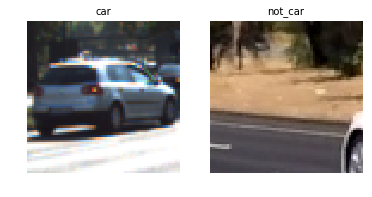

In [5]:
fig,axs = plt.subplots(1,2)
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('car', fontsize=10)
axs[0].imshow(car_exam)
axs[1].axis('off')
axs[1].set_title('not_car', fontsize=10)
axs[1].imshow(notcar_exam)
plt.savefig('output_images/imge_example.jpg')

### Spatial Binning of Color

In [3]:
# Define a function to compute binned color features
# Code from class
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

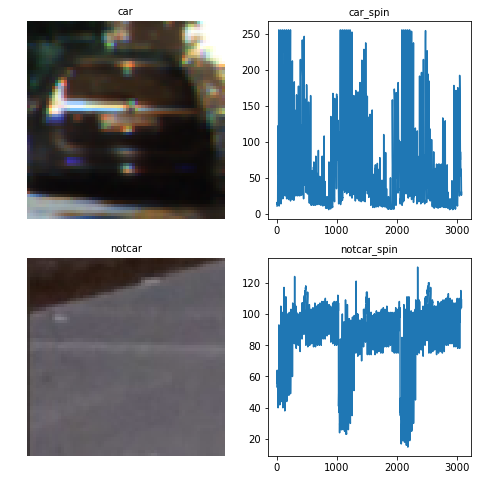

In [24]:
car_exam = cv2.imread(cars[np.random.randint(0,len(cars))])
notcar_exam = cv2.imread(notcars[np.random.randint(0,len(notcars))])
car_bin_vec = bin_spatial(car_exam)
notcar_bin_vec = bin_spatial(notcar_exam)
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.ravel()
axs[0].axis('off')
axs[0].set_title('car', fontsize=10)
axs[0].imshow(car_exam)
axs[1].set_title('car_spin', fontsize=10)
axs[1].plot(car_bin_vec)
axs[2].axis('off')
axs[2].set_title('notcar', fontsize=10)
axs[2].imshow(notcar_exam)
axs[3].set_title('notcar_spin', fontsize=10)
axs[3].plot(notcar_bin_vec)
plt.savefig('output_images/bin_spatial.jpg')

### Histograms of Color

In [4]:
# Define a function to compute color histogram features  
# Code from class
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins,range=(0,256))
    channel2_hist = np.histogram(img[:,:,1], bins=nbins,range=(0,256))
    channel3_hist = np.histogram(img[:,:,2], bins=nbins,range=(0,256))
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist,channel2_hist,channel3_hist,hist_features

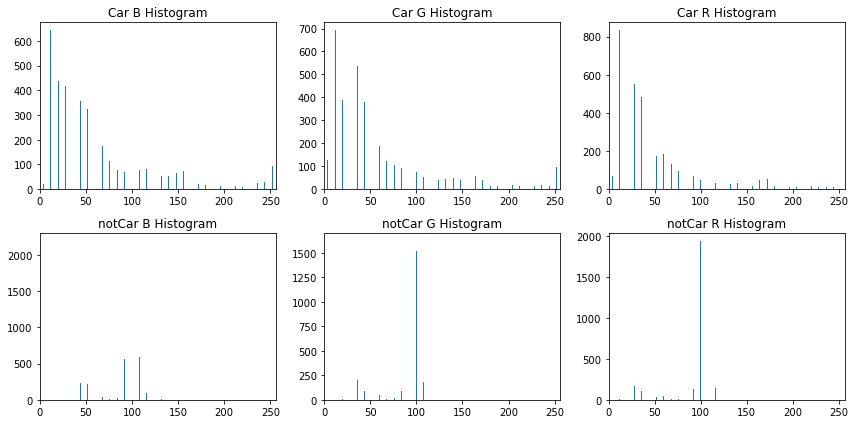

In [26]:
car_ch1,car_ch2,car_ch3,car_hist = color_hist(car_exam)
notcar_ch1,notcar_ch2,notcar_ch3,notcar_hist = color_hist(notcar_exam)
bincent = (car_ch1[1][0:len(car_ch1[1])-1] + car_ch1[1][1:])/2
#print(notcar_ch1[0])
#print(bincent)
fig = plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.bar(bincent, car_ch1[0])
plt.xlim(0, 256)
plt.title('Car B Histogram')
plt.subplot(2,3,2)
plt.bar(bincent, car_ch2[0])
plt.xlim(0, 256)
plt.title('Car G Histogram')
plt.subplot(2,3,3)
plt.bar(bincent, car_ch3[0])
plt.xlim(0, 256)
plt.title('Car R Histogram')
plt.subplot(2,3,4)
plt.bar(bincent, notcar_ch1[0])
plt.xlim(0, 256)
plt.title('notCar B Histogram')
plt.subplot(2,3,5)
plt.bar(bincent, notcar_ch2[0])
plt.xlim(0, 256)
plt.title('notCar G Histogram')
plt.subplot(2,3,6)
plt.bar(bincent, notcar_ch3[0])
plt.xlim(0, 256)
plt.title('notCar R Histogram')
fig.tight_layout()
plt.savefig('output_images/color_hist.jpg')

### Extract HOG features

In [5]:
# Define a function to return HOG features and visualization
# Code from class
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

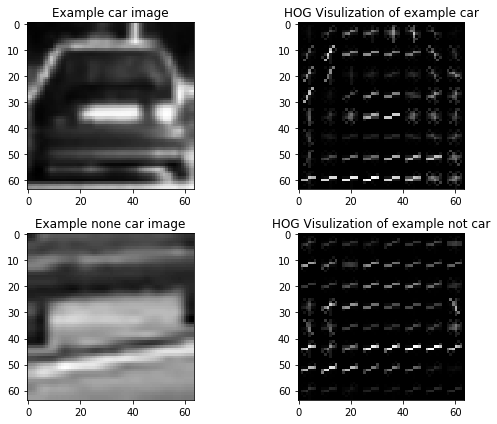

In [13]:
gray_car = cv2.cvtColor(car_exam, cv2.COLOR_RGB2GRAY)
gray_ncar = cv2.cvtColor(notcar_exam, cv2.COLOR_RGB2GRAY)
_, car_hog =  get_hog_features(gray_car, 9, 8, 2, vis=True, feature_vec = False)
_, ncar_hog =  get_hog_features(gray_ncar, 9, 8, 2, vis=True, feature_vec = False)
fig = plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.imshow(gray_car, cmap='gray')
plt.title('Example car image')
plt.subplot(2,2,2)
plt.imshow(car_hog, cmap='gray')
plt.title('HOG Visulization of example car')
plt.subplot(2,2,3)
plt.imshow(gray_ncar, cmap='gray')
plt.title('Example none car image')
plt.subplot(2,2,4)
plt.imshow(ncar_hog, cmap='gray')
plt.title('HOG Visulization of example not car')
fig.tight_layout()
plt.savefig('output_images/HOG.jpg')

### Extract features function

In [6]:
# Define a function to extract features from a list of images
#Code from class
def extract_features(imgs, color_space='RGB', spatial_size=(32,32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            _,_,_,hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Train the classifier

In [29]:
# Train the svc classifier:
# step1:Extract features
# step2:Split the dataset into train and test
# step3:Normalize the data
# step4:Train
# step5:output the accuracy
cspace='YUV'
size=(32, 32)
orient=9
nbins=32
#bins_range=(0, 256)
pix_per_cell=8
cell_per_block= 2
hog_channel= 'ALL'
spatial_feat = True 
hist_feat = True 
hog_feat = True 


t = time.time()
car_features = extract_features(cars, color_space=cspace, 
                        spatial_size=size, hist_bins=nbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=cspace, 
                        spatial_size=size, hist_bins=nbins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
#print(X_train.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t,2), 'Seconds to train SVC')
accuracy = round(svc.score(X_test, y_test), 4)
print('accuracy', accuracy)


148.97 Seconds to extract features
27.7 Seconds to train SVC
accuracy 0.9856


| COnfiguration label| Colorspace| Orientations| Pixles Per Cell| Cells Per Block|Hog Channel|Extract Time|Accuracy|Train Time|
|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|:-------------:|     
| 1      | YUV        | 9| 8| 2| ALL| 149.32| 0.9831 |27.79
| 2      | YCrCb      | 9| 8| 2| ALL| 183.14| 0.9809 |29.85
| 3      | RGB        | 9| 8| 2| ALL| 190.05| 0.9662 |48.64
| 4      | HSV        | 9| 8| 2| ALL| 175.42| 0.9817 |34.04
| 5      | HLS        | 9| 8| 2| ALL| 182.96| 0.9794 |36.26
| 6      | YUV        | 9| 8| 2| 1| 76.5| 0.9685 |21.44
| 7      | YUV        | 9| 8| 2| 2| 83.85| 0.9648 |21.09
| 8      | YUV        | 12| 8| 2| 1| 79.54| 0.969 |23.02
| 9      | YUV        | 7| 8| 2| 1| 75.61| 0.9657 |18.83
| 10      | YUV        | 5| 8| 2| 1| 90.25| 0.9648 |16.84
| 11      | YUV        | 7| 16| 2| 1| 106.36| 0.9657 |19.23
| 12      | YUV        | 7| 4| 2| 1| 329.37| 0.9628 |46.9
| 13      | YUV        | 7| 8| 1| 1| 176.13| 0.9595 |22.34
| 14      | YUV        | 7| 8| 3| 1| 193.77| 0.9662 |26.37



### Vehicle detect and track

In [9]:
# Save the training data
save_dict = {'X_scaler':X_scaler, 'svc':svc}
with open('Train_data.pickle','wb') as file:
    pickle.dump(save_dict, file)

In [7]:
# Load the training data
with open('Train_data.pickle','rb') as file:
    train_data = pickle.load(file)
X_scaler = train_data['X_scaler']
svc = train_data['svc']

In [8]:
# Define a function to draw boxes on the image
def draw_box(draw_img,window_list, color):
    for window in window_list:
        cv2.rectangle(draw_img,*window,color,6)
    return draw_img
        

In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img = img.astype(np.float32)/255
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        _,_,_,hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

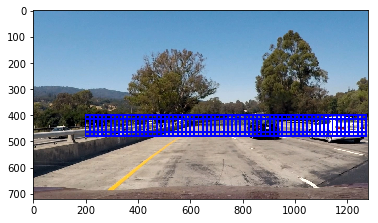

In [29]:
img = mpimg.imread('test_images/test1.jpg')
draw_img = np.copy(img)
windows = slide_window(img, x_start_stop=[200, 1280], y_start_stop=[400, 480], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
draw_img = draw_box(draw_img,windows,(0,0,255))
plt.figure()
plt.imshow(draw_img)
plt.savefig('output_images/boxes_with64size.jpg')

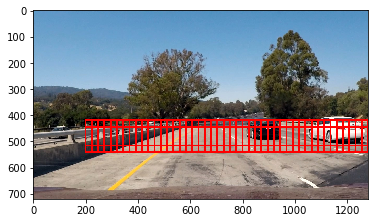

In [30]:
img = mpimg.imread('test_images/test1.jpg')
draw_img = np.copy(img)
windows = slide_window(img, x_start_stop=[200, 1280], y_start_stop=[420, 560], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
draw_img = draw_box(draw_img,windows,(255,0,0))
plt.figure()
plt.imshow(draw_img)
plt.savefig('output_images/boxeswith96size.jpg')

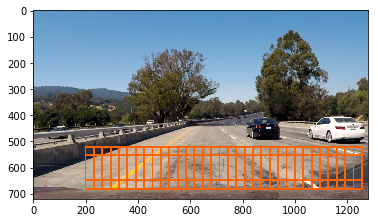

In [31]:
img = mpimg.imread('test_images/test1.jpg')
draw_img = np.copy(img)

windows = slide_window(img, x_start_stop=[200, 1280], y_start_stop=[520, 680], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
draw_img = draw_box(draw_img,windows,(255,100,0))
plt.figure()
plt.imshow(draw_img)
plt.savefig('output_images/boxeswith128size.jpg')

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

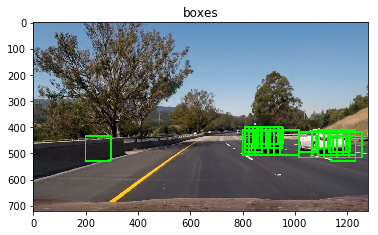

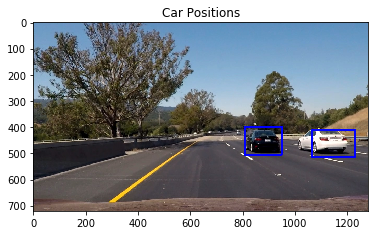

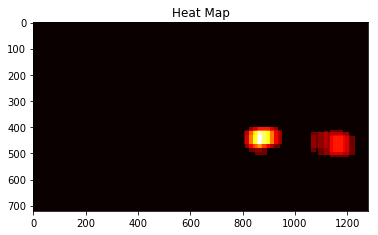

In [32]:
img = mpimg.imread('test_images/test6.jpg')
draw_img = np.copy(img)
rect_list = []
cspace='YUV'
spatial_size=(32, 32)
orient=9
hist_bins=32
bins_range=(0, 256)
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'


rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[400, 480], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)))


rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[410, 530], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75)))

rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[420, 530], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)))

rect_list.append(slide_window(img, x_start_stop=[650, 1280], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)))


rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[500, 628], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)))

#rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[, 648], 
                    #xy_window=(128, 128), xy_overlap=(0.5, 0.5)))

#rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[500, 680], 
                    #xy_window=(160, 160), xy_overlap=(0.5, 0.5)))


#rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[500, 680], 
                    #xy_window=(160, 160), xy_overlap=(0.5, 0.5)))

rect_list = [item for sub_rect_list in rect_list for item in sub_rect_list]
windows = search_windows(img, rect_list, svc, X_scaler, cspace, 
                    spatial_size, hist_bins, 
                    bins_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel)
draw_img = draw_box(draw_img,windows,(100,255,100))
#plt.figure()
#plt.imshow(draw_img)

heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
raw_img = draw_box(np.copy(img), windows,(0,255,0))
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.imshow(raw_img)
plt.title('boxes')
plt.savefig('output_images/imagewithboxes.jpg')
fig = plt.figure()
plt.imshow(draw_img)
plt.title('Car Positions')
plt.savefig('output_images/car position.jpg')
fig = plt.figure()
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.savefig('output_images/heatmap.jpg')

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [14]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [27]:
def pipeline(img):
    rect_list = []
    cspace='YUV'
    spatial_size=(32, 32)
    orient=9
    hist_bins=32
    bins_range=(0, 256)
    pix_per_cell=8
    cell_per_block=2
    hog_channel='ALL'
    #rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[400, 528], 
                    #xy_window=(64, 64), xy_overlap=(0.5, 0.5)))

    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[400, 480], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)))


    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[410, 530], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75)))

    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[420, 530], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)))

    rect_list.append(slide_window(img, x_start_stop=[650, 1280], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)))


    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[500, 628], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)))

   
    rect_list = [item for sub_rect_list in rect_list for item in sub_rect_list]
    # print(rect_list)

    windows = search_windows(img, rect_list, svc, X_scaler, cspace, 
                    spatial_size, hist_bins, 
                    bins_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel)
    #draw_img = draw_box(draw_img,windows,(100,255,100))
    #plt.figure()
    #plt.imshow(draw_img)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows)
    
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels)
    raw_img = draw_box(np.copy(img), windows,(0,255,0))
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

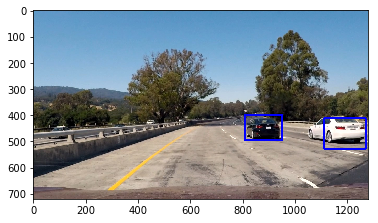

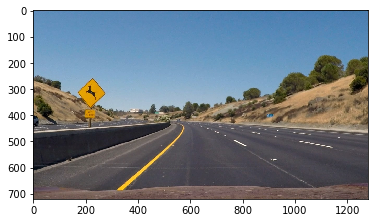

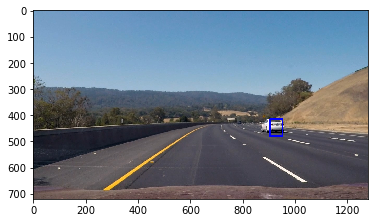

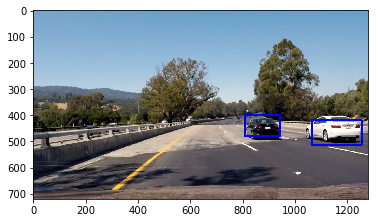

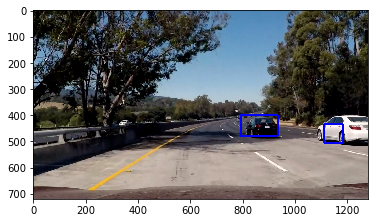

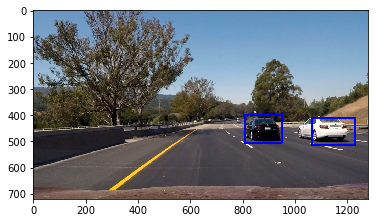

In [28]:
images = glob.glob('test_images/*.jpg')
i=0
for img in images:
    raw_img = mpimg.imread(img)
    out_img = pipeline(raw_img)
    plt.figure()
    plt.imshow(out_img)
    plt.savefig('output_images/'+str(i)+'carpos.jpg')
    i+=1

In [20]:
# Class definition
class veh():
    def __init__(self):
        self.current_heat = []
        self.avg_heat = None
        self.best_heat = None
        self.labels=None
    # Add a heat
    def add_fit(self,heat):
        if np.max(heat)!= 0:
            self.current_heat.append(heat)
            # Only keep 10 newest heats
            if len(self.current_heat) > 10:
                self.current_heat = self.current_heat[len(self.current_heat)-10:]
            # best heat is the average of the newest current fits
            self.avg_heat = np.average(self.current_heat, axis = 0)
        # If the new fit is None, the current fits should discard the oldest one
        else:
            if len(self.current_heat) > 0:
                self.current_heat = self.current_heat[1 : ]
            if len(self.current_heat) > 0:
                self.avg_heat = np.average(self.current_heat, axis = 0)

In [21]:
def pipeline(img):
    rect_list = []
    cspace='YUV'
    spatial_size=(32, 32)
    orient=9
    hist_bins=32
    bins_range=(0, 256)
    pix_per_cell=8
    cell_per_block=2
    hog_channel='ALL'
    #rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[400, 528], 
                    #xy_window=(64, 64), xy_overlap=(0.5, 0.5)))

    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[400, 480], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)))


    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[410, 530], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75)))

    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[420, 530], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5)))

    rect_list.append(slide_window(img, x_start_stop=[650, 1280], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)))


    rect_list.append(slide_window(img, x_start_stop=[200, 1280], y_start_stop=[500, 628], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)))

   
    rect_list = [item for sub_rect_list in rect_list for item in sub_rect_list]
    # print(rect_list)

    windows = search_windows(img, rect_list, svc, X_scaler, cspace, 
                    spatial_size, hist_bins, 
                    bins_range, orient, 
                    pix_per_cell, cell_per_block, 
                    hog_channel)
    #draw_img = draw_box(draw_img,windows,(100,255,100))
    #plt.figure()
    #plt.imshow(draw_img)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,windows)
    vehicle.add_fit(heat)
    #print(np.max(vehicle.avg_heat))
    heatmap = np.clip(vehicle.avg_heat, 0, 255)
    #heatmap = np.clip(heat, 0, 255)
    # Apply threshold to help remove false positives
    heat_map = apply_threshold(heatmap,2)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [22]:
vehicle=veh()
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [02:04<00:03,  3.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 2min 5s


In [23]:
vehicle=veh()
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(pipeline)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:09:49<00:03,  3.33s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 1h 9min 50s
